# 02 Uudiste kogumine Delfi veebilehelt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
from estnltk import Text

Delfi veebilehtelt  https://www.delfi.ee/archive/ koguti veebiämblikuga uudisartiklite lingid. Kogutud lingid on failis:  delfiscraper/delfiscraper/spiders/delfi_päevauudised_2020_03122020.csv 
Linkide kogumiseks kasutatud valikukriteeriumid:
1) periood: 01.01.2020 – 03.12.2020

2) kanal: Delfi

3) kategooria: päevauudised

In [58]:
# Delfi veebilehelt veebiämblikuga kogutud lingid loetakse listi

# list Delfi linkide jaoks
urls_delfi_toor = []

with open('delfiscraper/delfiscraper/spiders/delfi_päevauudised_2020_03122020.csv', 'r', encoding = 'utf-8') as f:
    reader = csv.reader(f)
    for line in reader:
        if line != []:
            urls_delfi_toor.append(line[0])
# linkide failis esimene rida ei ole uudise link
print(len(urls_delfi_toor)-1)

7497


In [56]:
# võimalike topeltlinkide eemaldamine
urls_delfi_e = list(dict.fromkeys(urls_delfi_toor))
print("Delfi veebilehtedelt kogutud linkide arv: ", len(urls_delfi_e)-1)

Delfi veebilehtedelt kogutud linkide arv:  7497


Hennoste on  raamatus (Hennoste, T. (2008). Uudise käsiraamat. Tartu: Tartu Ülikooli kirjastus) esitanud International Press Institute´i uudiste jaotuse: 

• kõvad uudised: sõda, poliitika, välissuhted, riigikaitse, majandus; 

• pehmed uudised: kultuur, haridus, teadus ja tehnika, sotsiaalsed sündmused, human interest (üldhuvi teemad), kuritegevus, õnnetused ja kuritööd, sport, usk jne (Hennoste 2008:24). 

Projekti eesmärk on uurida eelkõige sise- ja välispoliitika uudiseid, majandusuudiseid, teadusuudiseid. Seetõttu jäetakse vaatluse alt välja nn pehmed uudised (krimiuudised, kultuuriuudised, meelelahutusuudised). Samuti ei vaadelda "Eesti Ekspressi" artikleid kui nädalalehe-tüüpi artikleid.

In [57]:
#krimiuudiste, kultuuriuudiste, teemalehtede, "Kroonika", "Eesti Ekspressi" artiklite linkide eemaldamine
urls_delfi = []
krimi = 'https://www.delfi.ee/news/paevauudised/krimi/'
kultuur = 'https://epl.delfi.ee/kultuur/'
kroonika  = 'https://kroonika.delfi.ee/'
ekspress = 'https://ekspress.delfi.ee/'
teemalehed = 'https://www.delfi.ee/teemalehed/'
for link in urls_delfi_e:
    if kultuur not in link and krimi not in link and kroonika not in link and ekspress not in link and teemalehed not in link:
        urls_delfi.append(link)
print("Delfi veebilehtedelt kogutud uuritavate linkide arv: ",len(urls_delfi)-1)

Delfi veebilehtedelt kogutud uuritavate linkide arv:  6598


Delfi veebilehtedelt kogutud linkidelt saadakse BeautifulSoup abil järgmine info:

1) väljaande nimi

2) artikli pealkiri

3) artikli tekst

4) artikli publitseerimise kuupäev

In [5]:
headers = requests.utils.default_headers()
headers.update(
  { 'User-Agent': 'my crawler (anneliis@ut.ee) / on studying purpose', }
)

pealkirjad = []
tekstid = []
väljaanded = []
ajad =[]

for url in tqdm(urls_delfi[1:]):
    try:
        yhendatud_tekst = []
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        väljaanne = soup.find("meta", {"property" :"og:site_name"})['content']

        pealkiri = soup.find("meta", {"property" :"og:title"})['content']
        
        artik = "article__body"
        publits = {"property" : "article:published_time"}
        
        # Eesti Päevalehe ja Maalehe artiklite tekst ja publitseerimisaeg on kirjeldatud teistest artiklitest erinevalt
        
        if väljaanne == 'Eesti Päevaleht' or väljaanne == 'Maaleht':
            artik = "G-col-article"
            publits = {"name": "cXenseParse:recs:publishtime"}
                    
        tekst = soup.findAll("div",{"class" : artik})
        for t in tekst:
            p = t.find_all('p')
            for r in p:
                yhendatud_tekst.append(r.text)
          
        tekstid.append(yhendatud_tekst)

        aeg = soup.find("meta", publits)['content']
        
    except Exception as e:
        print("Exception is :", e, url)
        
    pealkirjad.append(pealkiri)
    väljaanded.append(väljaanne)
    ajad.append(aeg)
    artikkel = [' '.join(article) for article in tekstid]

100%|████████████████████████████████████████████████████████████████████████████| 6598/6598 [1:34:46<00:00,  1.16it/s]


Kogutud info uudisartiklite kohta koondatakse sõnastikuks.

In [6]:
artiklid = {'title': pealkirjad, 'text': artikkel,'subject': väljaanded, 'date': ajad, 'link': urls_delfi[1:]}

Kogutud sõnastik esitatakse tabeli kujul. Tabelis on viis veergu:

1) artikli pealkiri

2) artikli tekst

3) artikli väljaandja

4) artikli publitseerimise kuupäev

5) artikli link

In [7]:
data_delfi = pd.DataFrame(artiklid, columns = ['title', 'text','subject', 'date', 'link'])

In [8]:
data_delfi.shape

(6598, 5)

Järgnevalt filtreeritakse välja tühjade väljadega uudisartiklid.

In [9]:
data_delfi.dropna(inplace=True)

In [10]:
data_delfi.shape

(6598, 5)

In [11]:
data_delfi = data_delfi[(data_delfi.text != '') & (data_delfi.title != '') & (data_delfi.subject != '') & (data_delfi.date != '') ] 

In [12]:
data_delfi.shape

(6516, 5)

subject
Alkeemia             12
Anne & Stiil         10
Delfi              5304
Eesti Naine           3
Eesti Päevaleht     815
Forte                61
Ilmateade            32
Kasulik              15
Kinoveeb              2
Lemmikloom           13
Maakodu              12
Maaleht              16
Naistekas            34
Oma Maitse            1
Pere ja Kodu          4
Sport                13
Tervis Pluss          2
Ärileht             167
Name: text, dtype: int64


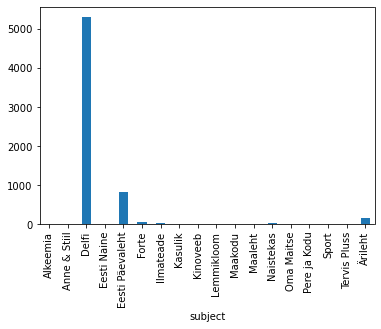

In [13]:
# Artiklite jaotus väljaandjate kaupa
print(data_delfi.groupby(['subject'])['text'].count())
data_delfi.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

Filteeritakse välja nn pehmed uudised (meelelahutus, ilmateade, sport jms).

In [14]:
#mittesobivate artiklite eemaldamine
delfi_filter = data_delfi[(data_delfi['subject'] != 'Alkeemia') & (data_delfi['subject'] != 'Anne & Stiil') 
                        & (data_delfi['subject'] != 'Anne & Stiil Web') & (data_delfi['subject'] != 'Eesti Naine')
                        & (data_delfi['subject'] != 'Ilmateade') & (data_delfi['subject'] != 'Kasulik')
                        & (data_delfi['subject'] != 'Kinoveeb') & (data_delfi['subject'] != 'LP')
                        & (data_delfi['subject'] != 'Lemmikloom') & (data_delfi['subject'] != 'Maakodu')
                        & (data_delfi['subject'] != 'Maakodu')
                        & (data_delfi['subject'] != 'Oma Maitse') & (data_delfi['subject'] != 'Naistekas')
                        & (data_delfi['subject'] != 'Paber EPL') & (data_delfi['subject'] != 'Pere ja Kodu')
                        & (data_delfi['subject'] != 'Sport') & (data_delfi['subject'] != 'Tervis Pluss')
                        & (data_delfi['subject'] != 'Delfi TV') & (data_delfi['subject'] != 'Reisijuht')].reset_index(drop = True)

subject
Delfi              5304
Eesti Päevaleht     815
Forte                61
Maaleht              16
Ärileht             167
Name: text, dtype: int64


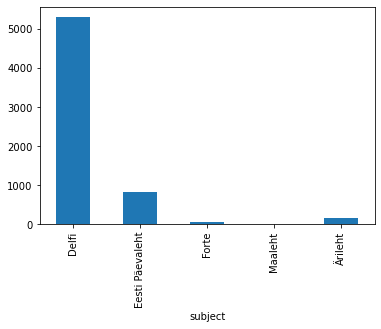

In [15]:
# Artiklite jaotus väljaandjate kaupa
print(delfi_filter.groupby(['subject'])['text'].count())
delfi_filter.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [50]:
delfi_filter.shape

(6363, 5)

In [52]:
delfi_filter.to_csv('data_delfi_UUS.csv',index=False)

# Sõnapilvede loomine

In [78]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

## Nimi- ja omadussõnade kasutamine

EstNLTK vahenditega vaadeldakse Delfi uudistes esinevate sõnade lemmasid ja sõnade liike. Edaspidiseks vaatluseks eraldatakse nimisõnad (sõnaliik S) ja  omadussõnad (sõnaliigid A - algvõrre, C - keskvõrre, U - ülivõrre).

In [79]:
# Delfi uudistes nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad = []
for i in tqdm(range (0, len(delfi_filter))):
    rida = delfi_filter.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad.append(sona[0][0])

nimi_omadus_words = ' '.join(map(str, nimi_omadus_sonad))

100%|██████████████████████████████████████████████████████████████████████████████| 6363/6363 [40:13<00:00,  2.64it/s]


Nimisõnu ja omadussõnu sõnapilves:  847760


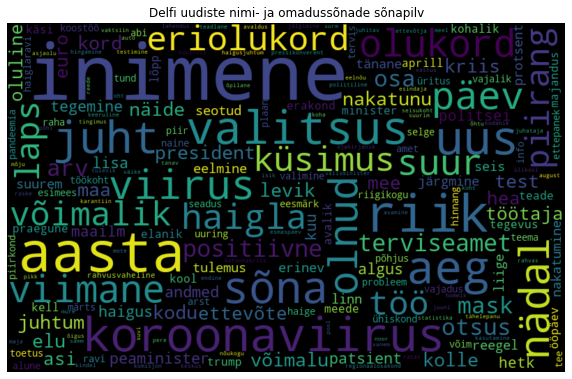

In [80]:
wordcloud_nimi_omadus = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus, interpolation='bilinear')
plt.title("Delfi uudiste nimi- ja omadussõnade sõnapilv")
plt.savefig('Delfi_uudiste_nimi_omadus_sõnapilv_UUS.png')
plt.axis("off")
print("Nimisõnu ja omadussõnu sõnapilves: ", len(nimi_omadus_sonad))

## Nimi- ja omadussõnade esinemissagedus ning osakaal

In [118]:
df_1 =pd.DataFrame(nimi_omadus_sonad, columns=['sõna'])
sagedused_1 = df_1.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
sagedused_1['osakaal %']= (sagedused_1['esinemissagedus']/len(nimi_omadus_sonad)*100)

In [119]:
print("Delfi uudiste nimisõnade ja omadussõnade TOP 10")
sagedused_1

Delfi uudiste nimisõnade ja omadussõnade TOP 10


,sõna,esinemissagedus,osakaal %
9036,inimene,16825,1.984642
897,aasta,7615,0.898250
29445,riik,6558,0.773568
14663,koroonaviirus,5325,0.628126
37803,uus,5301,0.625295
38482,valitsus,5196,0.612909
1128,aeg,5162,0.608899
9933,juht,4709,0.555464
32936,sõna,4699,0.554284
22880,nädal,4154,0.489997


## Verbide kasutamine

100%|██████████████████████████████████████████████████████████████████████████████| 6363/6363 [39:04<00:00,  2.71it/s]


(-0.5, 799.5, 499.5, -0.5)

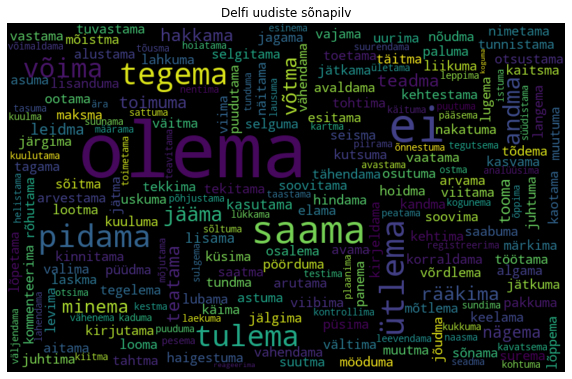

In [37]:
verb_sonad = []
for i in tqdm(range (0, len(delfi_filter))):
    rida = delfi_filter.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad.append(sona[0][0])

verb_words = ' '.join(map(str, verb_sonad))

wordcloud_verb = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb, interpolation='bilinear')
plt.title("Delfi uudiste verbide sõnapilv")
plt.savefig('Delfi_uudiste_sõnapilv_verb_sonad_UUS.png')
plt.axis("off")
print("Verbe sõnapilves: ", len(verb_sonad))

In [38]:
print("Verbe sõnapilves: ", len(verb_sonad))

Verbe sõnapilves:  439617


## Verbide esinemissagedus ja osakaal

In [120]:
df_2 =pd.DataFrame(verb_sonad, columns=['sõna'])
sagedused_2 = df_2.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
sagedused_2['osakaal %']= (sagedused_2['esinemissagedus']/len(verb_sonad)*100)

In [121]:
print("Delfi uudiste verbide TOP 10")
sagedused_2

Delfi uudiste verbide TOP 10


,sõna,esinemissagedus,osakaal %
1400,olema,100621,22.888332
196,ei,23805,5.414941
1831,saama,14718,3.347914
2633,ütlema,10291,2.340901
1520,pidama,9534,2.168706
2135,tegema,9226,2.098645
2241,tulema,8249,1.876406
2544,võima,6838,1.555445
66,andma,5103,1.160783
530,jääma,3971,0.903286
